## Сравнение uniform и Xavier на MNIST

In [28]:
import torch 
import torchvision
import tqdm as notebook_tqdm
import torch.nn as nn

### Загрузка данных

In [29]:
from torchvision import datasets as dts
from torchvision.transforms import ToTensor 


n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [32]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Смотрим на данные 

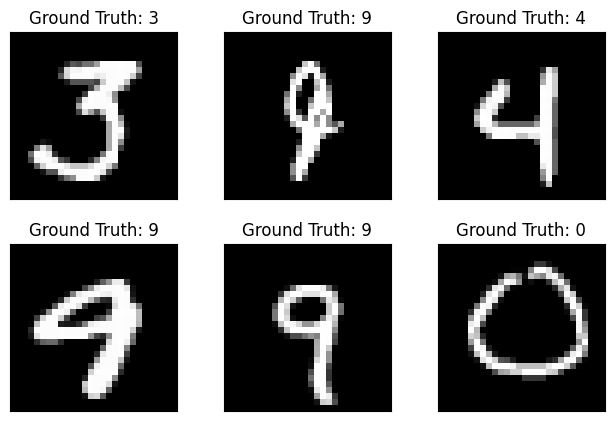

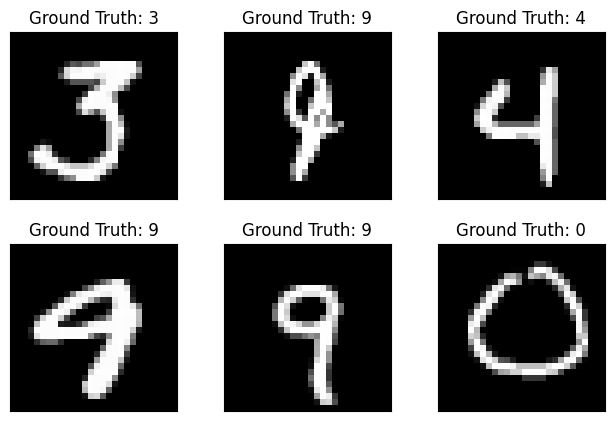

In [35]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [121]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import sqrt

### Модель с  uniform 

In [333]:

# созадем модель классивфикации изображений
class model_usual(nn.Module):
    def __init__(self):
        super( model_usual,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 100) 
        self.linear3 = nn.Linear(100, 100) 
        self.linear4 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)

        nn.init.uniform_(self.linear1.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear2.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear3.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear4.weight, 0, 1/sqrt(5))
        
        self.tanh = nn.Tanh()

    def forward(self, image):
        a = image.view(-1, 28*28)
        a = self.tanh(self.linear1(a))
        a = self.tanh(self.linear2(a))
        a = self.tanh(self.linear3(a))
        a = self.tanh(self.linear4(a))
        a = self.final(a)
        return F.log_softmax(a)

model = model_usual()
print(model)

model_usual(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (tanh): Tanh()
)


#### Обучение

In [334]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [335]:


# обучаем 
EPOCH = 30
train_losses = []
train_counter = []



count = 0
for e in range(EPOCH):
  for batch_idx, (data, target) in enumerate(train_loader):
    
    # фиксируем количество примеров 
    count+=1
    train_counter.append(count)
    
    optimizer.zero_grad()

    y_pred = model.forward(data)
    loss_vall =  F.nll_loss(y_pred, target)
    

    loss_vall.backward()
    optimizer.step()

    loss_vall = loss_vall.detach().numpy()

    if not e % 1000:
      print('Loss - ', loss_vall)
    
    train_losses.append(loss_vall)

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_67659/668619945.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)


Loss -  2.3501668
Loss -  2.3736477
Loss -  2.2463758
Loss -  2.147738
Loss -  2.1962426
Loss -  2.305119
Loss -  2.2898421
Loss -  2.2011626
Loss -  2.331825
Loss -  2.1413684
Loss -  2.0113466
Loss -  2.2296457
Loss -  2.3507884
Loss -  2.1623855
Loss -  2.1559687
Loss -  2.15357
Loss -  2.286433
Loss -  2.3343253
Loss -  2.2208183
Loss -  2.3010685
Loss -  2.184286
Loss -  2.1487856
Loss -  2.3040013
Loss -  2.183187
Loss -  2.197523
Loss -  2.156997
Loss -  2.139255
Loss -  2.215408
Loss -  2.1866398
Loss -  2.1696324
Loss -  2.190044
Loss -  2.205939
Loss -  2.1233902
Loss -  2.2474437
Loss -  2.1941516
Loss -  2.254542
Loss -  2.2119482
Loss -  2.1728067
Loss -  2.2122881
Loss -  2.1926372
Loss -  2.305486
Loss -  2.3568473
Loss -  2.2674341
Loss -  2.1952267
Loss -  2.2024035
Loss -  2.1943612
Loss -  2.1865463
Loss -  2.2378414
Loss -  2.2618427
Loss -  2.1985826
Loss -  2.1832836
Loss -  2.209926
Loss -  2.1863496
Loss -  2.2314415
Loss -  2.2290537
Loss -  2.2794538
Loss -  2

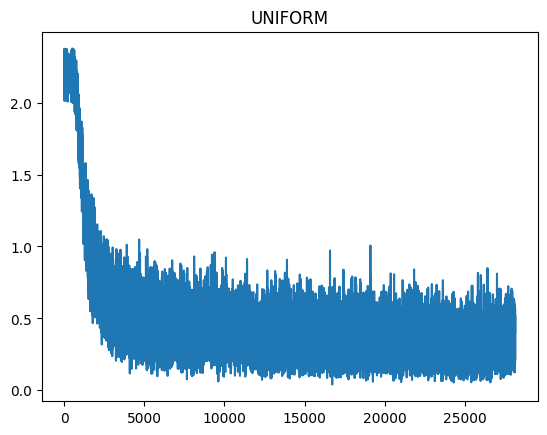

In [336]:
fig, ax = plt.subplots()  
ax.set_title('UNIFORM')
ax.plot(train_counter, train_losses)  

#### Результаты на тестовой выборке

In [337]:
model.eval()
test_losses = []
test_loss = 0
num  = []

cur = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
      cur+=1
      num.append(cur)
      
      output = model(data)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      
      correct += pred.eq(target.data.view_as(pred)).sum()
      
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_67659/668619945.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)



Test set: Avg. loss: 0.0325, Accuracy: 891/10000 (9%)


Test set: Avg. loss: 0.0364, Accuracy: 1781/10000 (18%)


Test set: Avg. loss: 0.0354, Accuracy: 2670/10000 (27%)


Test set: Avg. loss: 0.0374, Accuracy: 3554/10000 (36%)


Test set: Avg. loss: 0.0384, Accuracy: 4437/10000 (44%)


Test set: Avg. loss: 0.0345, Accuracy: 5325/10000 (53%)


Test set: Avg. loss: 0.0388, Accuracy: 6204/10000 (62%)


Test set: Avg. loss: 0.0398, Accuracy: 7078/10000 (71%)


Test set: Avg. loss: 0.0365, Accuracy: 7959/10000 (80%)


Test set: Avg. loss: 0.0355, Accuracy: 8842/10000 (88%)



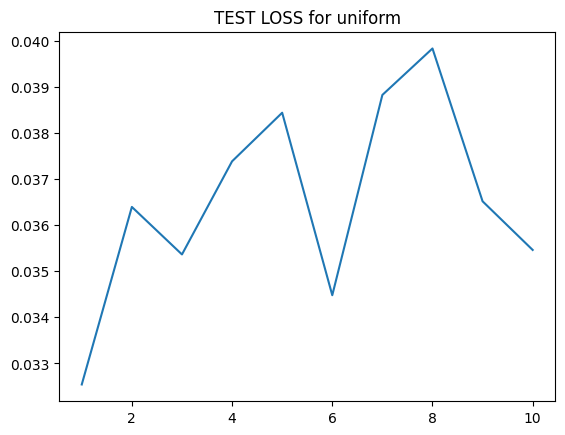

In [338]:
fig, ax = plt.subplots()  
ax.set_title('TEST LOSS for uniform')
ax.plot(num, test_losses)  

### Визуализируем резульат

In [306]:
import numpy as np
def predict(model, example):
    output = model.forward(example).detach().numpy()
    return np.argmax(output)

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_67659/668619945.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)


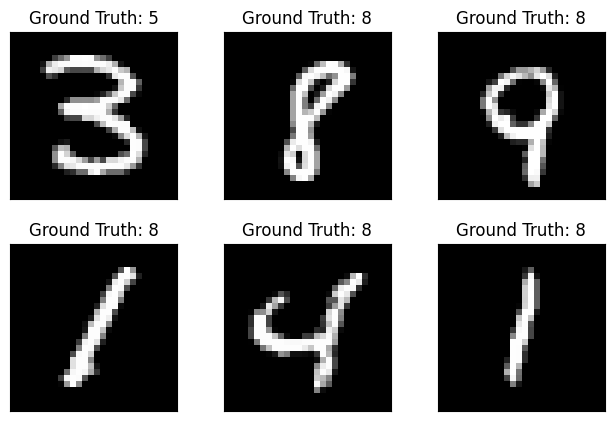

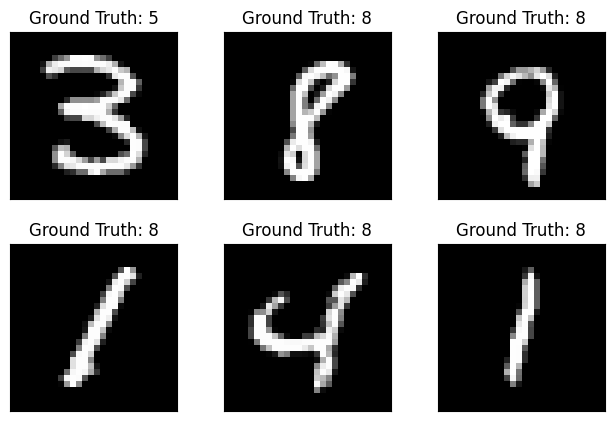

In [311]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(predict(model,example_data[i][0])))
  plt.xticks([])
  plt.yticks([])
fig

### Модель с инициализацией Xavier

In [322]:

# созадем модель классивфикации изображений
class model_xavier(nn.Module):
    def __init__(self):
        super( model_xavier,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 100) 
        self.linear3 = nn.Linear(100, 100) 
        self.linear4 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)

        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.linear4.weight)
        
        self.tanh = nn.Tanh()

    def forward(self, image):
        a = image.view(-1, 28*28)
        a = self.tanh(self.linear1(a))
        a = self.tanh(self.linear2(a))
        a = self.tanh(self.linear3(a))
        a = self.tanh(self.linear4(a))
        a = self.final(a)
        return F.log_softmax(a)

model_xavier = model_xavier()
print(model_xavier)

model_xavier(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (tanh): Tanh()
)


### Обучение

In [323]:
optimizer_x = torch.optim.Adam(model_xavier.parameters(), lr=0.005)

In [324]:

# обучаем 
EPOCH = 30
train_losses_x = []
train_counter_x = []


count = 0
for e in range(EPOCH):
  for batch_idx, (data, target) in enumerate(train_loader):
    
    # фиксируем количество примеров 
    count+=1
    train_counter_x.append(count)
    
    optimizer_x.zero_grad()

    y_pred = model_xavier.forward(data)
    loss_vall =  F.nll_loss(y_pred, target)
    

    loss_vall.backward()
    optimizer_x.step()

    loss_vall = loss_vall.detach().numpy()

    if not e % 1000:
      print('Loss - ', loss_vall)
    
    train_losses_x.append(loss_vall)

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_67659/3850764671.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)


Loss -  2.3562143
Loss -  2.2191029
Loss -  2.120645
Loss -  1.8462951
Loss -  1.6985489
Loss -  1.4277675
Loss -  1.3822149
Loss -  1.2722062
Loss -  1.1870189
Loss -  1.0128664
Loss -  1.1128806
Loss -  0.95416296
Loss -  0.8814277
Loss -  0.808412
Loss -  0.7934118
Loss -  0.8283009
Loss -  0.67675954
Loss -  0.58440113
Loss -  0.8080892
Loss -  0.5868897
Loss -  0.5632822
Loss -  0.58811975
Loss -  0.72518474
Loss -  0.73609626
Loss -  0.59012914
Loss -  0.5822297
Loss -  0.60591096
Loss -  0.7038577
Loss -  0.46432778
Loss -  0.32373717
Loss -  0.45965436
Loss -  0.3940836
Loss -  0.54325926
Loss -  0.29837137
Loss -  0.5013128
Loss -  0.46608144
Loss -  0.4502706
Loss -  0.27250564
Loss -  0.38110462
Loss -  0.69398814
Loss -  0.5518805
Loss -  0.38728717
Loss -  0.43089312
Loss -  0.19746193
Loss -  0.5383031
Loss -  0.36203066
Loss -  0.4405555
Loss -  0.36211017
Loss -  0.4819596
Loss -  0.44060284
Loss -  0.46456435
Loss -  0.2820299
Loss -  0.43627277
Loss -  0.40999675
Loss

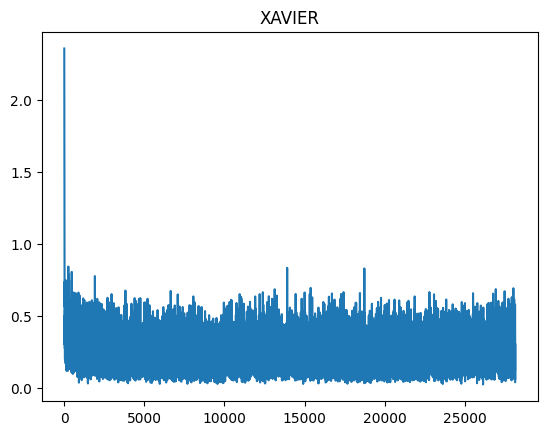

In [326]:
fig, ax = plt.subplots()  
ax.set_title('XAVIER')
ax.plot(train_counter_x, train_losses_x)  

### Сравниваем два метода инициализайии весов

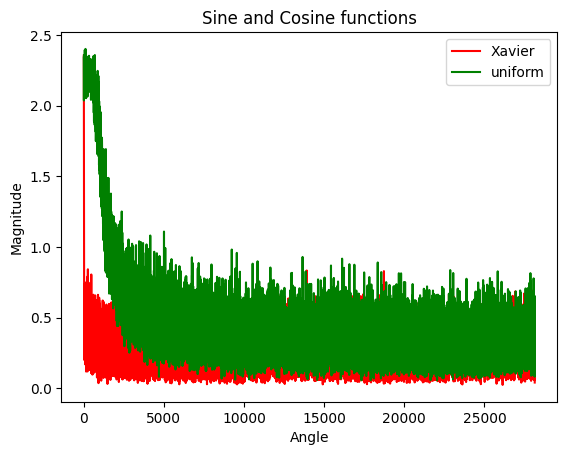

In [327]:

X = train_counter_x
  
# Assign variables to the y axis part of the curve
y = train_losses_x
z = train_losses
  
# Plotting both the curves simultaneously
plt.plot(X, y, color='r', label='Xavier')
plt.plot(X, z, color='g', label='uniform')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Angle")
plt.ylabel("Magnitude")
plt.title("Sine and Cosine functions")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Видно, что с помощью метода Ксавье можно достич лучшей сходимости 

### Резултаты второй модели 

In [329]:
model_xavier.eval()

test_losses_x = []
num = []

test_loss = 0
correct = 0
cur = 0
with torch.no_grad():
    for data, target in test_loader:
      cur+=1
      num.append(cur)
      
      output = model_xavier(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      
      test_loss /= len(test_loader.dataset)
      test_losses_x.append(test_loss)
      
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_67659/3850764671.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)
/Users/kodin/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0297, Accuracy: 916/10000 (9%)


Test set: Avg. loss: 0.0247, Accuracy: 1844/10000 (18%)


Test set: Avg. loss: 0.0244, Accuracy: 2774/10000 (28%)


Test set: Avg. loss: 0.0212, Accuracy: 3713/10000 (37%)


Test set: Avg. loss: 0.0246, Accuracy: 4638/10000 (46%)


Test set: Avg. loss: 0.0266, Accuracy: 5565/10000 (56%)


Test set: Avg. loss: 0.0230, Accuracy: 6497/10000 (65%)


Test set: Avg. loss: 0.0291, Accuracy: 7417/10000 (74%)


Test set: Avg. loss: 0.0297, Accuracy: 8341/10000 (83%)


Test set: Avg. loss: 0.0266, Accuracy: 9261/10000 (93%)



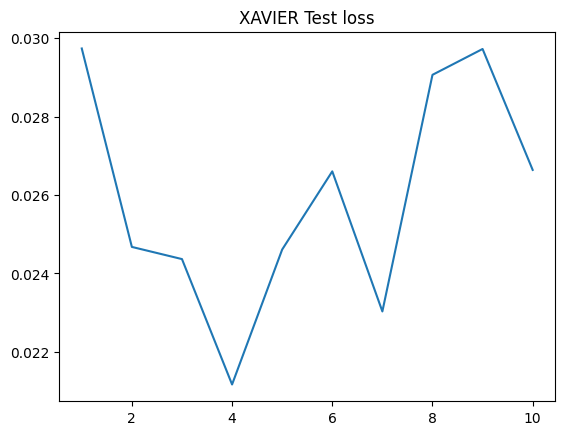

In [330]:
fig, ax = plt.subplots()  
ax.set_title('XAVIER Test loss')
ax.plot(num, test_losses_x)  

### Визуализируем резуьтат

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_67659/3850764671.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)


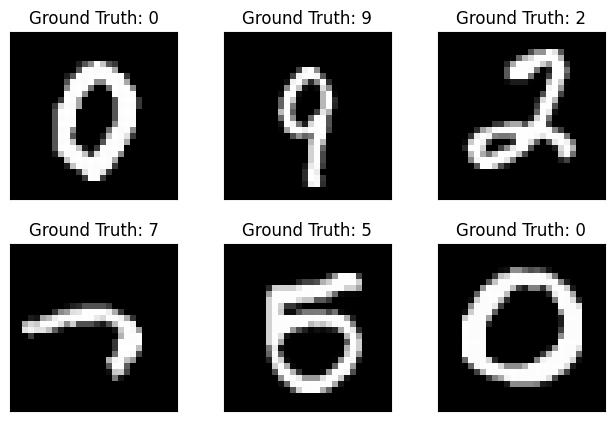

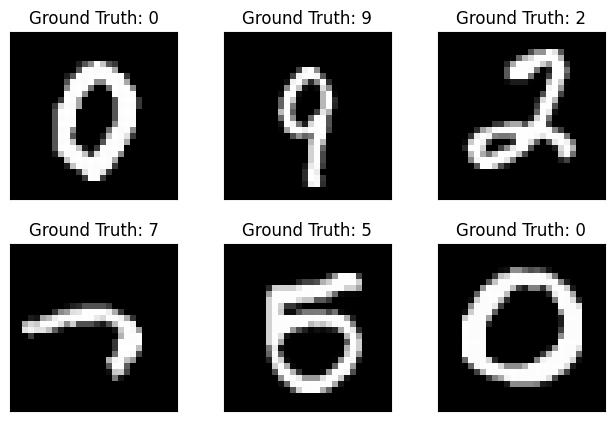

In [339]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(predict(model_xavier, example_data[i][0])))
  plt.xticks([])
  plt.yticks([])
fig